## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb

import tensorflow as tf

import mimic_iv_utils as utils

from functools import reduce

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

## 2. Fetch Data

In [3]:
static = utils.getStaticFeatures()
first_lab = utils.getLabFeatures(duration=24)
last_lab = utils.getLabFeatures(mode='last', duration=24)
first_vitals = utils.getVitalsFeatures(duration=24)
last_vitals = utils.getVitalsFeatures(mode='last', duration=24)
max_vitals = utils.getMinMaxVitalsFeatures(mode='max', duration=24)
min_vitals = utils.getMinMaxVitalsFeatures(duration=24)
avg_vitals = utils.getMinMaxVitalsFeatures(mode='avg', duration=24)
mortality = utils.getInhospitalMortality()
filtered = utils.getFilteredCohort(duration=24)

dfs = [filtered, static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)

## 3. Data Distribution

In [3]:
selection = [ 'age',
 'bmi',
 'height',
 'weight',
 'bun_first',
 'chloride_first',
 'creatinine_first',
 'hgb_first',
 'platelet_first',
 'potassium_first',
 'sodium_first',
 'tco2_first',
 'wbc_first',
 'bg_po2_first',
 'bg_pco2_first',
 'bg_ph_first',
 'bg_baseexcess_first',
 'bg_carboxyhemoglobin_first',
 'bg_methemomoglobin_first',
 'aniongap_first',
 'albumin_first',
 'bands_first',
 'bicarbonate_first',
 'bilrubin_first',
 'glucose_first',
 'hematocrit_first',
 'lactate_first',
 'ptt_first',
 'inr_first',
 'bun_last',
 'chloride_last',
 'creatinine_last',
 'hgb_last',
 'platelet_last',
 'potassium_last',
 'sodium_last',
 'tco2_last',
 'wbc_last',
 'bg_po2_last',
 'bg_pco2_last',
 'bg_ph_last',
 'bg_baseexcess_last',
 'bg_carboxyhemoglobin_last',
 'bg_methemomoglobin_last',
 'aniongap_last',
 'albumin_last',
 'bands_last',
 'bicarbonate_last',
 'bilrubin_last',
 'glucose_last',
 'hematocrit_last',
 'lactate_last',
 'ptt_last',
 'inr_last',
 'heartrate_first',
 'sysbp_first',
 'diabp_first',
 'meanbp_first',
 'resprate_first',
 'tempc_first',
 'spo2_first',
 'gcseye_first',
 'gcsverbal_first',
 'gcsmotor_first',
 'heartrate_last',
 'sysbp_last',
 'diabp_last',
 'meanbp_last',
 'resprate_last',
 'tempc_last',
 'spo2_last',
 'gcseye_last',
 'gcsverbal_last',
 'gcsmotor_last',
 'heartrate_max',
 'sysbp_max',
 'diabp_max',
 'meanbp_max',
 'resprate_max',
 'tempc_max',
 'spo2_max',
 'gcseye_max',
 'gcsverbal_max',
 'gcsmotor_max',
 'heartrate_min',
 'sysbp_min',
 'diabp_min',
 'meanbp_min',
 'resprate_min',
 'tempc_min',
 'spo2_min',
 'gcseye_min',
 'gcsverbal_min',
 'gcsmotor_min',
 'heartrate_avg',
 'sysbp_avg',
 'diabp_avg',
 'meanbp_avg',
 'resprate_avg',
 'tempc_avg',
 'spo2_avg',
 'gcseye_avg',
 'gcsverbal_avg',
 'gcsmotor_avg']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(13, 8, figsize=(15,30))
for i, col in enumerate(selection):
    ax = sns.histplot(data[col], hue=data.hospital_expire_flag, ax=axes.flatten()[i])
plt.show()

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does n

## 3. Outliers

In [3]:
data

,stay_id,subject_id,hadm_id,is_male,age,race_white,race_black,race_hispanic,race_asian,race_other,...,sysbp_avg,diabp_avg,meanbp_avg,resprate_avg,tempc_avg,spo2_avg,gcseye_avg,gcsverbal_avg,gcsmotor_avg,hospital_expire_flag
0,31793211,17867402,24528534,1,25.0,0,0,0,0,0,...,135.941176,69.117647,86.529412,16.187500,36.960317,97.000000,2.900000,2.800000,5.2,0
1,31983544,14435996,28960964,1,49.0,1,0,0,0,0,...,151.739130,89.521739,107.304348,16.384615,36.977778,99.555556,3.428571,2.428571,5.5,0
2,33183475,17609946,27385897,1,70.0,1,0,0,0,0,...,104.250000,50.250000,67.250000,17.761905,37.214286,97.142857,2.600000,1.000000,5.0,1
3,34547665,12776735,20817525,1,80.0,0,0,0,0,1,...,125.000000,64.615385,81.083333,17.916667,37.666667,94.538462,3.615385,5.000000,6.0,0
4,34569476,10215159,24283593,0,67.0,1,0,0,0,0,...,131.826087,61.956522,77.826087,22.147059,37.263889,97.882353,4.000000,5.000000,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54602,39989105,16926631,25623508,0,71.0,0,1,0,0,0,...,137.454545,84.545455,99.863636,17.166667,36.953704,98.666667,4.000000,5.000000,6.0,0
54603,39990717,17984318,21944963,0,75.0,1,0,0,0,0,...,129.304348,58.826087,76.260870,18.428571,36.722222,98.500000,4.000000,5.000000,6.0,0
54604,39991872,15721773,28911582,1,61.0,1,0,0,0,0,...,130.926829,71.317073,85.512195,18.560976,36.755556,96.047619,4.000000,5.000000,6.0,0
54605,39992247,12275003,22562812,1,72.0,0,0,0,0,0,...,109.740741,53.703704,70.407407,13.193548,NaN,98.600000,3.000000,3.400000,5.0,0


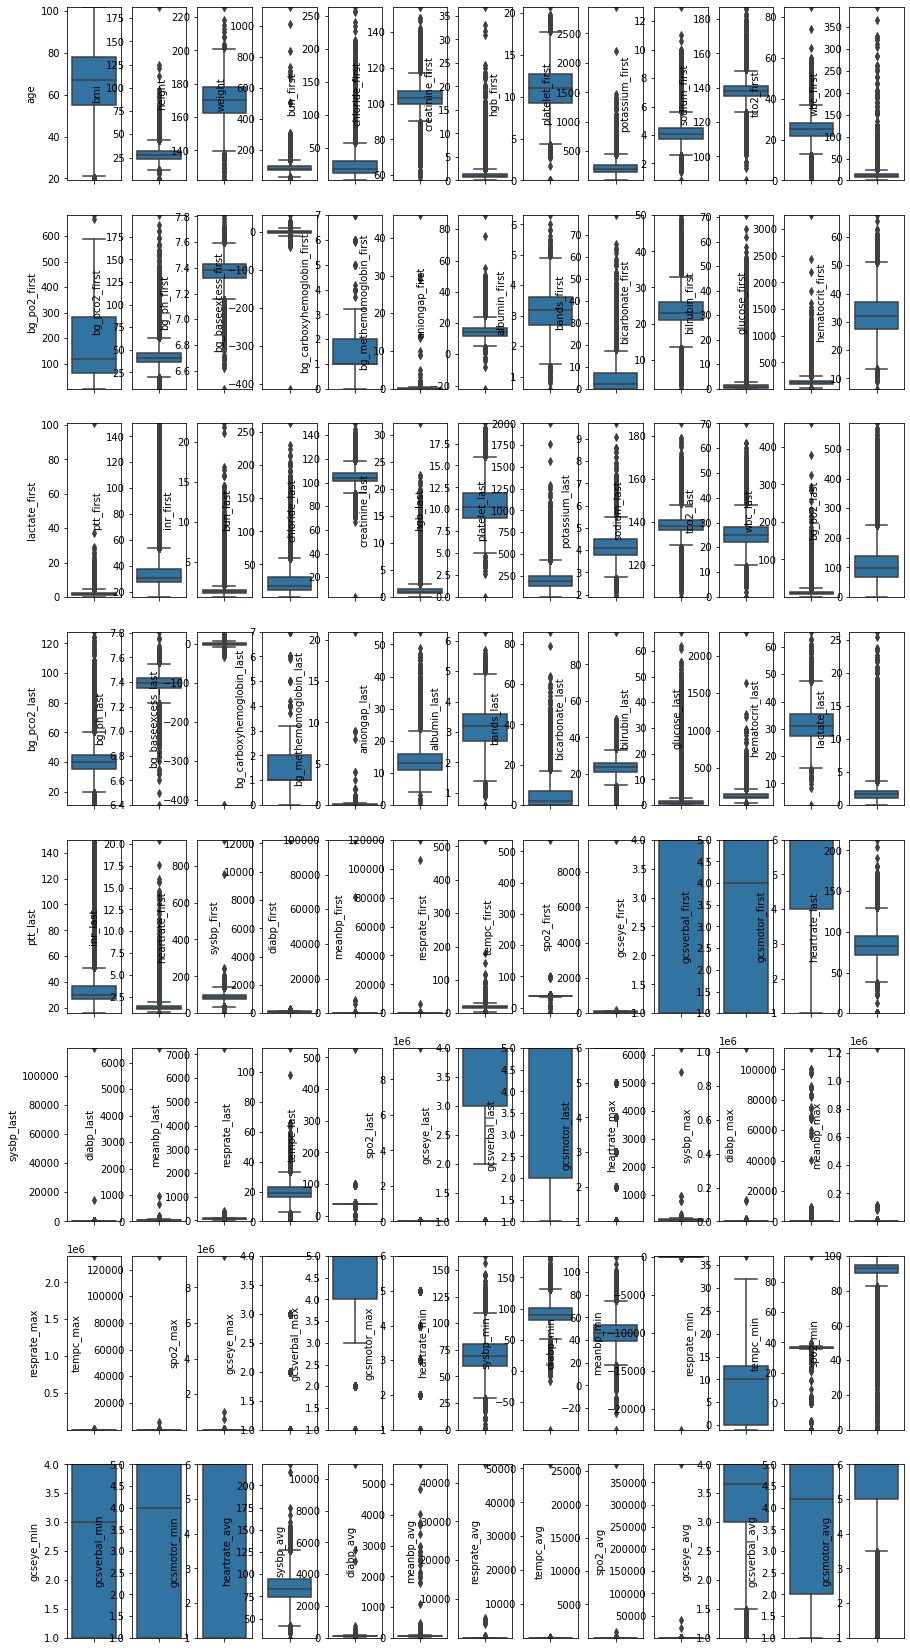

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

selection = [ 'age',
 'bmi',
 'height',
 'weight',
 'bun_first',
 'chloride_first',
 'creatinine_first',
 'hgb_first',
 'platelet_first',
 'potassium_first',
 'sodium_first',
 'tco2_first',
 'wbc_first',
 'bg_po2_first',
 'bg_pco2_first',
 'bg_ph_first',
 'bg_baseexcess_first',
 'bg_carboxyhemoglobin_first',
 'bg_methemomoglobin_first',
 'aniongap_first',
 'albumin_first',
 'bands_first',
 'bicarbonate_first',
 'bilrubin_first',
 'glucose_first',
 'hematocrit_first',
 'lactate_first',
 'ptt_first',
 'inr_first',
 'bun_last',
 'chloride_last',
 'creatinine_last',
 'hgb_last',
 'platelet_last',
 'potassium_last',
 'sodium_last',
 'tco2_last',
 'wbc_last',
 'bg_po2_last',
 'bg_pco2_last',
 'bg_ph_last',
 'bg_baseexcess_last',
 'bg_carboxyhemoglobin_last',
 'bg_methemomoglobin_last',
 'aniongap_last',
 'albumin_last',
 'bands_last',
 'bicarbonate_last',
 'bilrubin_last',
 'glucose_last',
 'hematocrit_last',
 'lactate_last',
 'ptt_last',
 'inr_last',
 'heartrate_first',
 'sysbp_first',
 'diabp_first',
 'meanbp_first',
 'resprate_first',
 'tempc_first',
 'spo2_first',
 'gcseye_first',
 'gcsverbal_first',
 'gcsmotor_first',
 'heartrate_last',
 'sysbp_last',
 'diabp_last',
 'meanbp_last',
 'resprate_last',
 'tempc_last',
 'spo2_last',
 'gcseye_last',
 'gcsverbal_last',
 'gcsmotor_last',
 'heartrate_max',
 'sysbp_max',
 'diabp_max',
 'meanbp_max',
 'resprate_max',
 'tempc_max',
 'spo2_max',
 'gcseye_max',
 'gcsverbal_max',
 'gcsmotor_max',
 'heartrate_min',
 'sysbp_min',
 'diabp_min',
 'meanbp_min',
 'resprate_min',
 'tempc_min',
 'spo2_min',
 'gcseye_min',
 'gcsverbal_min',
 'gcsmotor_min',
 'heartrate_avg',
 'sysbp_avg',
 'diabp_avg',
 'meanbp_avg',
 'resprate_avg',
 'tempc_avg',
 'spo2_avg',
 'gcseye_avg',
 'gcsverbal_avg',
 'gcsmotor_avg']
# plt.figure(figsize=(15,30))
fig, axes = plt.subplots(8, 13, figsize=(15,30))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=data[col], ax=axes.flatten()[i])
    ax.set_ylim(data[col].min(), data[col].max())
    ax.set_ylabel(col)
plt.show()


In [5]:
outliers_list = []
for i, col in enumerate(selection):
    median = data[col].median()
    std = data[col].std()
    outliers = (data[col] - median).abs() > std
    outliers_list.append([col, outliers.sum()/data.shape[0]])
outliers_df = pd.DataFrame(outliers_list, columns=['column', 'outliers_ratio'])
outliers_df = outliers_df.sort_values(by=['outliers_ratio'], ascending=[False])

<BarContainer object of 104 artists>

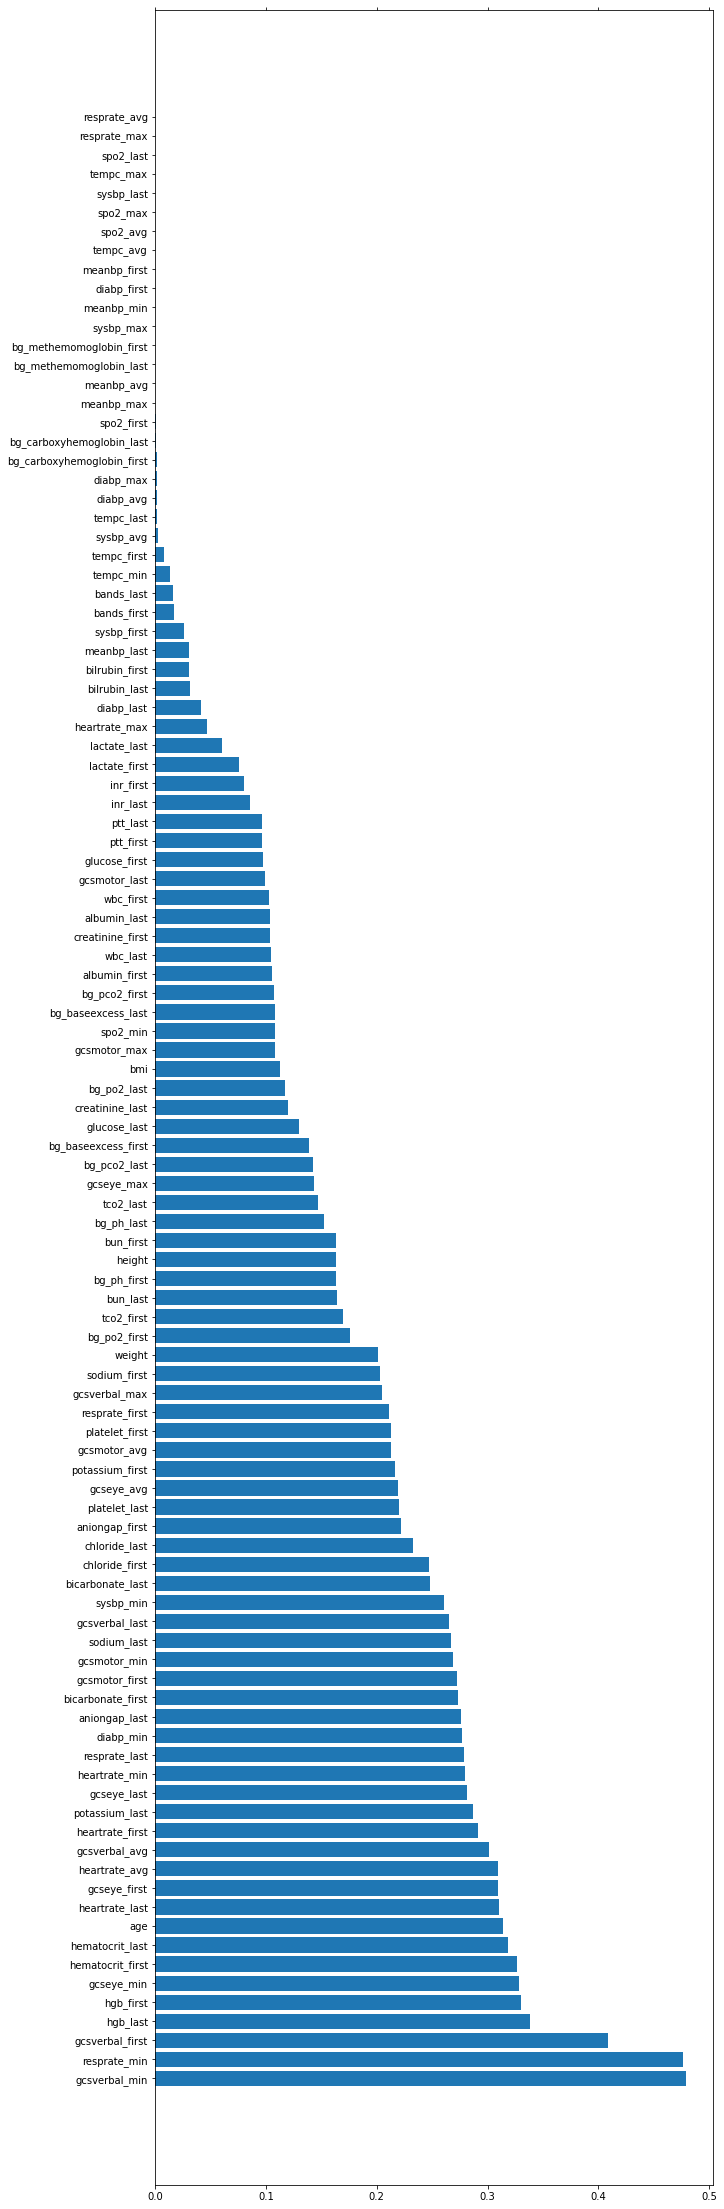

In [6]:
plt.figure(figsize=(10,40))
plt.tick_params(top="on")
plt.barh(y=outliers_df.column, width=outliers_df.outliers_ratio)

## 4. Deep Learning with Outliers

In [7]:
X = data.values
y = X[:,-1]
y = y.astype('int')
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train_array = np.asarray(X_train).astype('float32')
X_test_array = np.asarray(X_test).astype('float32')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_array)
X_train_imputed = imp_mean.transform(X_train_array)
X_test_imputed = imp_mean.transform(X_test_array)
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_imputed)
X_train_noralized = normalizer(X_train_imputed)
X_test_noralized = normalizer(X_test_imputed)

model = Sequential()
model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

probs = model.predict(X_test_noralized)

Epoch 1/5
171/171 [==============================] - 22s 5ms/step - loss: 0.3876 - accuracy: 0.8195 - val_loss: 0.2178 - val_accuracy: 0.9140
Epoch 2/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9147 - val_loss: 0.2099 - val_accuracy: 0.9163
Epoch 3/5
171/171 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9193 - val_loss: 0.2061 - val_accuracy: 0.9172
Epoch 4/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1995 - accuracy: 0.9208 - val_loss: 0.2055 - val_accuracy: 0.9170
Epoch 5/5
171/171 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.9211 - val_loss: 0.2036 - val_accuracy: 0.9170


ROC:  0.908415523756468
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      9816
           1       0.66      0.36      0.47      1106

    accuracy                           0.92     10922
   macro avg       0.80      0.67      0.71     10922
weighted avg       0.90      0.92      0.91     10922



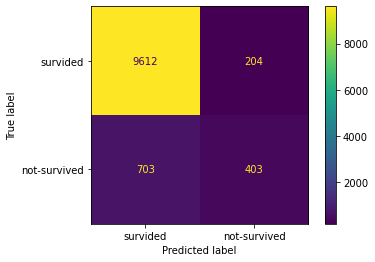

In [9]:
preds = np.around(probs)

roc_score = metrics.roc_auc_score(y_test, probs)

print('ROC: ', roc_score)

classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['survided', 'not-survived'])
disp.plot()

## 5. Deep Learning without Outliers

In [10]:
outliers_list = []
for i, col in enumerate(selection):
    median = data[col].median()
    std = data[col].std()
    outliers = (data[col] - median).abs() > std
    data[col][outliers] = np.nan
    data[col].fillna(median, inplace=True)

<ipython-input-10-08efcdf11249>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][outliers] = np.nan
<ipython-input-10-08efcdf11249>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][outliers] = np.nan
<ipython-input-10-08efcdf11249>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][outliers] = np.nan
<ipython-input-10-08efcdf11249>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [11]:
X = data.values
y = X[:,-1]
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train_array = np.asarray(X_train).astype('float32')
X_test_array = np.asarray(X_test).astype('float32')
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_array)
X_train_imputed = imp_mean.transform(X_train_array)
X_test_imputed = imp_mean.transform(X_test_array)
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_imputed)
X_train_noralized = normalizer(X_train_imputed)
X_test_noralized = normalizer(X_test_imputed)

model = Sequential()
model.add(layers.Dense(X_train.shape[1], activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(40, activation=tf.nn.relu, kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train_noralized, y_train, validation_data=(X_test_noralized, y_test), epochs=5, batch_size=256)

probs = model.predict(X_test_noralized)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
preds = np.around(probs)

roc_score = metrics.roc_auc_score(y_test, probs)

print('ROC: ', roc_score)

classification_report = metrics.classification_report(y_test, preds)
print(classification_report)

cm = confusion_matrix(y_test, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['survided', 'not-survived'])
disp.plot()